In [1]:
from database.database import mongodb
import pandas as pd
import numpy as np
from ggplot import *
%matplotlib inline
from help.help import strTostr
import datetime as dt


In [29]:
def getSpot(code):
    """
    获取汇率对的实时汇率,用于把本金转化为美元
    """
    if code=='USD':
        return (1.0,'USDUSD')
    else:
        code1 = 'USD'+code.strip().upper()
        code2 = code.strip().upper() + 'USD'
        mongo = mongodb()
        data = mongo.select('kline_new',{'type':'0','code':{'$in':[code1,code2]}})
        mongo.close()
        
        if data!=[]:
            data = data[0]
            return  (data['Close']/1.0/data['PriceWeight'],data['code'])
        else:
             return None   
            
def gethistory(Currency):
    """获取汇率对的历史收盘价"""
    data =[]
    try:
       mongo = mongodb()
       data = mongo.select('kline',{'type':'5','code':Currency})
       mongo.close()
    except:
        pass
    if data!=[]:
        data = pd.DataFrame(data)
        data['Close'] = data['Close']/data['PriceWeight']
        data['High'] = data['High']/data['PriceWeight']
        data['Open'] = data['Open']/data['PriceWeight']
        data['LastClose'] = data['LastClose']/data['PriceWeight']
        data['Low'] = data['Low']/data['PriceWeight']
        data = data[['Close','High','LastClose','Low','Open','Time','code']]
        data['Time'] = data['Time'].map(lambda x:strTostr(x,'%Y-%m-%d %H:%M:%S','%Y-%m-%d'))
        data = data[['Time','Close']]
    return data


def timedelta(s,day,format='%Y-%m-%d'):
    """在当前日期上加减天数，返回对应的日期"""
    try:
      return (dt.datetime.strptime(s,format)+dt.timedelta(day)).strftime(format)
    except:
       return None
    
def dateseris(mindate,maxdate):
        """生成日期序列"""
        date = timedelta(mindate,0)
        series = []
        while maxdate>=date:
            series.append(date)

            date = timedelta(date,1)

        return series
def datafill(spots):
    """
    填充无交易日期的汇率
    以上一个交易日的的收盘价进行填充
    """
   
    spot = spots.copy()
    spot = pd.merge(pd.DataFrame(dateseris(spot['Time'].min(),spot['Time'].max()),columns=['Time']),spot[['Time','Close']],on=['Time'],how='left' )
    spot = spot.sort_values('Time')
    for i in range(spot.shape[0]):
        if spot['Close'].values[i].__str__()=='nan':
            spot['Close'].values[i] = spot['Close'].values[i-1]
    return spot

def lagdata(spots,lags=[30,60,180]):
    """
    spot：每天外汇收益率时间序列
    lags：时间长度
    序列指定时间长度的收益率
    """
    spot = datafill(spots)
    #for lag in lags:
    lag = lags[0]  
    spot['Close_%d'%lag] = np.repeat(None,lag).tolist() + spot['Close'].values[:-lag].tolist()
    spot['Close_%d_rate'%lag] = (spot['Close'] - spot['Close_%d'%lag])/spot['Close_%d'%lag]

    spot =  spot.dropna()
    return spot[['Time','Close_%d_rate'%lag]]


def getuniondata(data):
    uniondata = None
    for lst,index in zip(data[['Currency','DeliverDate','TradeDate']].values,data.index.values):
        currency = lst[0]
        lag = (lst[1] -lst[2]).days

        spots = gethistory(currency)
        spots = lagdata(spots,[lag])
        spots.columns = ['Time',currency+'_'+str(lag)+'_'+str(index)]
        if uniondata is None:
                uniondata = spots
        else:
               uniondata = pd.merge(uniondata,spots,on=['Time'])

    return uniondata
        

In [86]:
##测试数据集
colname = ['Currency',##货币对
           'K',##锁定汇率
           'Period',##期限
           'TradeDate',##交易日期
           'DeliverDate',##交割日期
           'Money',##本金
           'Code',##本金货币代码
          ]
data = [
        ['USDCNY',6.6685,'一个月','2016-10-01','2016-11-01',1000000,'USD'],
        ['USDCNY',6.6685,'三个月','2016-09-01','2016-12-01',3000000,'USD'],
        ['USDCNY',6.6685,'十二个月','2016-01-01','2016-12-31',5000000,'USD'],
        ['GBPCNY',8.2923,'十二个月','2016-02-01','2017-01-31',100000,'GBP'],
        ['GBPCNY',8.2923,'一个月','2016-10-01','2016-11-01',829230,'CNY'],
       ]
data = pd.DataFrame(data,columns = colname)
data['TradeDate'] = data['TradeDate'].astype(np.datetime64)
data['DeliverDate'] = data['DeliverDate'].astype(np.datetime64)

In [87]:
                           
                                           
data['USDMoney'] = data['Code'].map(lambda x:getSpot(x))    
data['USDpair'] = data['USDMoney'].map(lambda x:x[1])
data['USDMoney'] = data['USDMoney'].map(lambda x:x[0])
data['USDMoney'] = map(lambda lst:
                       lst['Money']/lst['USDMoney'] if 'USD'+lst['Code'].strip().upper()==lst['USDpair']
                       else lst['Money']/lst['USDMoney'],
                       data[['Code','USDpair','USDMoney','Money']].to_dict('records')
                      )
data['weight'] = data['USDMoney']/data['USDMoney'].sum()##获取每笔结构性产品在所有货币中所占的权重
data=data[['Currency','K','TradeDate','DeliverDate','weight']]##USDMoney美元金额
data=data[['Currency','K','TradeDate','DeliverDate','weight']]##USDMoney美元金额


In [93]:
def getdatarange(data):
    """获取"""
    dataframe = None
    data = data.sort_values('TradeDate')
    for lst,index in zip(data.to_dict('records'),data.index.values):
        Currency = lst['Currency']
        TradeDate = lst['TradeDate'].strftime('%Y-%m-%d')
        DeliverDate = lst['DeliverDate'].strftime('%Y-%m-%d')
        weight = lst['weight']
        
        temp = pd.DataFrame(dateseris(TradeDate,DeliverDate),columns=['Time'])
        temp[Currency+'_'+str(index)] = weight
        if dataframe is None:
            dataframe = temp
        else:
            dataframe = pd.merge(dataframe,temp,on='Time',how='outer')
    dataframe = dataframe.fillna(0)
    columns = dataframe.columns.tolist()[:]
    columns.remove('Time')
    Sum = dataframe[columns].sum(axis=1).values
    for column in columns:
        dataframe[column] = dataframe[column]/Sum

    return dataframe


In [74]:
def repeat(data,times):
    """
    对数据重复times
    """
    tempdata = data.copy()
    if times==1:
        return tempdata
    for i in range(times-1):
        tempdata = tempdata.append(data)
    tempdata.index =range(len(tempdata))
    return tempdata
    

In [94]:
uniondata = getuniondata(data)
datarange = getdatarange(data)
datarange = repeat(datarange.iloc[:,1:],int(np.ceil(uniondata.shape[0]/1.0/datarange.shape[0])))
datarange = datarange.iloc[0:uniondata.shape[0]]
uniondata['rate'] = (uniondata.iloc[:,1:].values*datarange.values).sum(axis=1)

In [112]:
uniondata.head()



,Time,USDCNY_31_0,USDCNY_91_1,USDCNY_365_2,GBPCNY_365_3,GBPCNY_31_4,rate
0,2013-10-29,-0.004609,-0.006817,-0.024634,-0.023906,-0.010291,-0.004609
1,2013-10-30,-0.003972,-0.005678,-0.023508,-0.026424,-0.011010,-0.003972
2,2013-10-31,-0.004199,-0.005856,-0.022911,-0.028183,-0.012994,-0.004199
3,2013-11-01,-0.003382,-0.004895,-0.022438,-0.034629,-0.019761,-0.003382
4,2013-11-02,-0.003382,-0.004895,-0.022752,-0.028672,-0.022356,-0.003382


In [113]:
temp = None
for group in ['USDCNY_31_0','USDCNY_91_1','USDCNY_365_2','GBPCNY_365_3','GBPCNY_31_4','rate']:
    tm = uniondata[['Time',group]]
    tm['group'] = group
    tm.columns = ['Time','rate','group']
    if temp is None:
        temp = tm
        
    else:
        temp = temp.append(tm)
       

/Users/lywen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


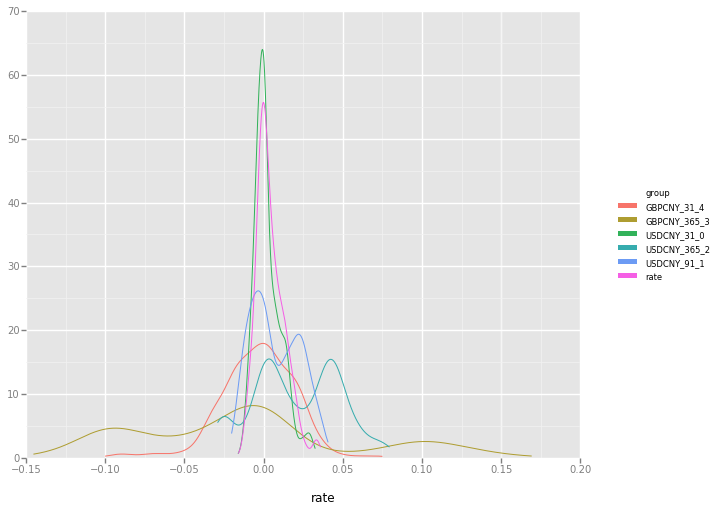

<ggplot: (296770737)>

In [114]:
p = ggplot(aes(x='rate',group='group',color='group'),temp)+geom_density()
p